### Clustering Data Using the k-means Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
input_file = ('Python-Machine-Learning-Cookbook-Second-Edition-master/Chapter04/data_multivar.txt')

# Load data
x = []
with open(input_file, 'r') as f:
    for line in f.readlines():
        data = [float(i) for i in line.split(',')]
        x.append(data)

data = np.array(x)
#data = utilities.load_data('data_multivar.txt')

([], <a list of 0 Text yticklabel objects>)

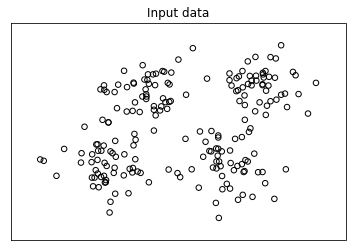

In [3]:
%matplotlib inline
# Plot data

plt.figure()
plt.scatter(data[:,0], data[:,1], marker='o', 
        facecolors='none', edgecolors='k', s=30)
x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
plt.title('Input data')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [4]:
num_clusters = 4

# Train the model
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

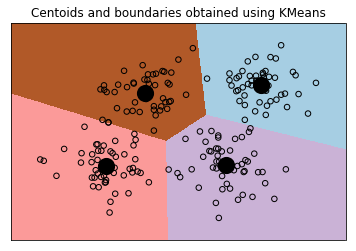

In [5]:
# Step size of the mesh
step_size = 0.01

# Plot the boundaries
x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
x_values, y_values = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

# Predict labels for all points in the mesh
predicted_labels = kmeans.predict(np.c_[x_values.ravel(), y_values.ravel()])

# Plot the results
predicted_labels = predicted_labels.reshape(x_values.shape)
plt.figure()
plt.clf()
plt.imshow(predicted_labels, interpolation='nearest',
           extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.scatter(data[:,0], data[:,1], marker='o', 
        facecolors='none', edgecolors='k', s=30)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], marker='o', s=200, linewidths=3,
        color='k', zorder=10, facecolors='black')
x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
plt.title('Centoids and boundaries obtained using KMeans')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Compressing an Image Using Vector Quantization

In [14]:
import numpy as np
from scipy import misc 
from sklearn import cluster
import matplotlib.pyplot as plt

In [58]:
def compress_image(img, num_clusters):
    # Convert input image into (num_samples, num_features) 
    # array to run kmeans clustering algorithm 
    X = img.reshape((-1, 1))  

    # Run kmeans on input data
    kmeans = cluster.KMeans(n_clusters=num_clusters, n_init=4, random_state=5)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_.squeeze()
    labels = kmeans.labels_

    # Assign each value to the nearest centroid and 
    # reshape it to the original image shape
    input_image_compressed = np.choose(labels, centroids).reshape(img.shape)
    
    return input_image_compressed

In [59]:
def plot_image(img, title):
    vmin = img.min()
    vmax = img.max()
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

The size of the image will be reduced by a factor of 2.0
Compression rate = 50.0%


/home/hussam/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


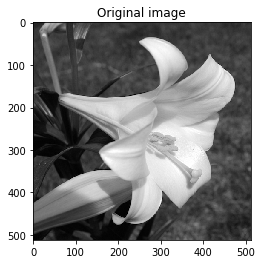

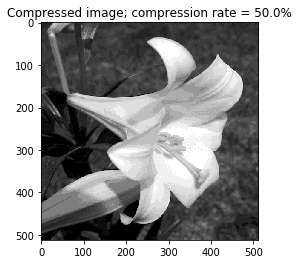

In [60]:
if __name__=='__main__':
    input_file = 'Python-Machine-Learning-Cookbook-Second-Edition-master/Chapter04/flower_image.jpg'
    num_bits = 4

    if not 1 <= num_bits <= 8:
        raise TypeError('Number of bits should be between 1 and 8')

    num_clusters = np.power(2, num_bits)

    # Print compression rate
    compression_rate = round(100 * (8.0 - num_bits) / 8.0, 2)
    print("The size of the image will be reduced by a factor of", 8.0/num_bits)
    print("Compression rate = " + str(compression_rate) + "%")

    # Load input image
    input_image = misc.imread(input_file, True).astype(np.uint8)

    # original image 
    plot_image(input_image, 'Original image')

    # compressed image 
    input_image_compressed = compress_image(input_image, num_clusters)
    plot_image(input_image_compressed, 'Compressed image; compression rate = ' 
            + str(compression_rate) + '%')

    plt.show()

### Grouping Data Using Agglomerative Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [2]:
def add_noise(x, y, amplitude):
    X = np.concatenate((x, y))
    X += amplitude * np.random.randn(2, X.shape[1])
    return X.T

def get_spiral(t, noise_amplitude=0.5):
    r = t
    x = r * np.cos(t)
    y = r * np.sin(t)

    return add_noise(x, y, noise_amplitude)

def get_rose(t, noise_amplitude=0.02):
    # Equation for "rose" (or rhodonea curve); if k is odd, then
    # the curve will have k petals, else it will have 2k petals
    k = 5       
    r = np.cos(k*t) + 0.25 
    x = r * np.cos(t)
    y = r * np.sin(t)

    return add_noise(x, y, noise_amplitude)

def get_hypotrochoid(t, noise_amplitude=0):
    a, b, h = 10.0, 2.0, 4.0
    x = (a - b) * np.cos(t) + h * np.cos((a - b) / b * t) 
    y = (a - b) * np.sin(t) - h * np.sin((a - b) / b * t) 

    return add_noise(x, y, 0)

In [3]:
def perform_clustering(X, connectivity, title, num_clusters=3, linkage='ward'):
    plt.figure()
    model = AgglomerativeClustering(linkage=linkage, 
                    connectivity=connectivity, n_clusters=num_clusters)
    model.fit(X)

    # extract labels
    labels = model.labels_

    # specify marker shapes for different clusters
    markers = '.vx'

    for i, marker in zip(range(num_clusters), markers):
        # plot the points belong to the current cluster
        plt.scatter(X[labels==i, 0], X[labels==i, 1], s=50, 
                    marker=marker, color='k', facecolors='none')

    plt.title(title)

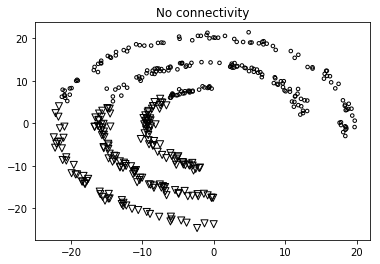

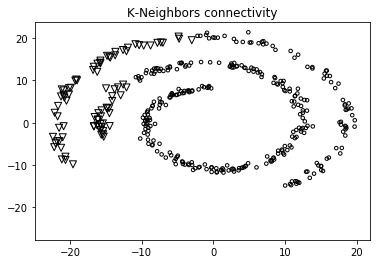

In [4]:
if __name__=='__main__':
    # Generate sample data
    n_samples = 500 
    np.random.seed(2)
    t = 2.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    X = get_spiral(t)

    # No connectivity
    connectivity = None 
    perform_clustering(X, connectivity, 'No connectivity')

    # Create K-Neighbors graph 
    connectivity = kneighbors_graph(X, 10, include_self=False)
    perform_clustering(X, connectivity, 'K-Neighbors connectivity')

    plt.show()

### Evaluating the Performance of Clustering Algorithms

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans

In [15]:
input_file = ('Python-Machine-Learning-Cookbook-Second-Edition-master/Chapter04/data_perf.txt')
# Load data
x = []
with open(input_file, 'r') as f:
    for line in f.readlines():
        data = [float(i) for i in line.split(',')]
        x.append(data)

data = np.array(x)

In [16]:
scores = []
range_values = np.arange(2, 10)

for i in range_values:
    # Train the model
    kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10)
    kmeans.fit(data)
    score = metrics.silhouette_score(data, kmeans.labels_, 
                metric='euclidean', sample_size=len(data))

    print("Number of clusters =", i)
    print("Silhouette score =", score)
                    
    scores.append(score)

Number of clusters = 2
Silhouette score = 0.5290397175472954
Number of clusters = 3
Silhouette score = 0.5551898802099927
Number of clusters = 4
Silhouette score = 0.5832757517829593
Number of clusters = 5
Silhouette score = 0.6582796909760834
Number of clusters = 6
Silhouette score = 0.600348303231998
Number of clusters = 7
Silhouette score = 0.5257914697918236
Number of clusters = 8
Silhouette score = 0.4629882197608102
Number of clusters = 9
Silhouette score = 0.4602848444467352


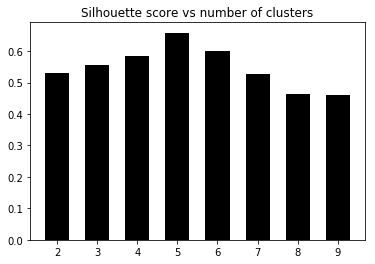

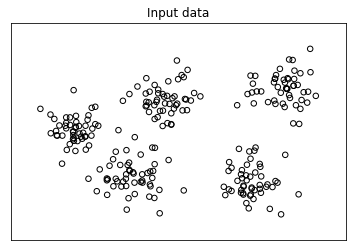

In [17]:
# Plot scores
plt.figure()
plt.bar(range_values, scores, width=0.6, color='k', align='center')
plt.title('Silhouette score vs number of clusters')

# Plot data
plt.figure()
plt.scatter(data[:,0], data[:,1], color='k', s=30, marker='o', facecolors='none')
x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
plt.title('Input data')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

### Estimating the Number of Clusters Using the DBSCAN Algorithm

In [18]:
from itertools import cycle

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt

In [19]:
input_file = ('Python-Machine-Learning-Cookbook-Second-Edition-master/Chapter04/data_perf.txt')
# Load data
x = []
with open(input_file, 'r') as f:
    for line in f.readlines():
        data = [float(i) for i in line.split(',')]
        x.append(data)

X = np.array(x)

In [20]:
# Find the best epsilon
eps_grid = np.linspace(0.3, 1.2, num=10)
silhouette_scores = []
eps_best = eps_grid[0]
silhouette_score_max = -1
model_best = None
labels_best = None
for eps in eps_grid:
    # Train DBSCAN clustering model
    model = DBSCAN(eps=eps, min_samples=5).fit(X)

    # Extract labels
    labels = model.labels_

    # Extract performance metric 
    silhouette_score = round(metrics.silhouette_score(X, labels), 4)
    silhouette_scores.append(silhouette_score)

    print("Epsilon:", eps, " --> silhouette score:", silhouette_score)

    if silhouette_score > silhouette_score_max:
        silhouette_score_max = silhouette_score
        eps_best = eps
        model_best = model
        labels_best = labels

Epsilon: 0.3  --> silhouette score: 0.1287
Epsilon: 0.39999999999999997  --> silhouette score: 0.3594
Epsilon: 0.5  --> silhouette score: 0.5134
Epsilon: 0.6  --> silhouette score: 0.6165
Epsilon: 0.7  --> silhouette score: 0.6322
Epsilon: 0.7999999999999999  --> silhouette score: 0.6366
Epsilon: 0.8999999999999999  --> silhouette score: 0.5142
Epsilon: 1.0  --> silhouette score: 0.5629
Epsilon: 1.0999999999999999  --> silhouette score: 0.5629
Epsilon: 1.2  --> silhouette score: 0.5629


Text(0.5, 1.0, 'Silhouette score vs epsilon')

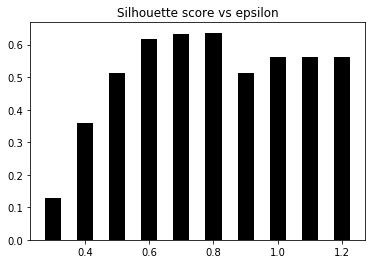

In [21]:
# Plot silhouette scores vs epsilon
plt.figure()
plt.bar(eps_grid, silhouette_scores, width=0.05, color='k', align='center')
plt.title('Silhouette score vs epsilon')

In [23]:
# Best params
print("Best epsilon =", eps_best)

# Associated model and labels for best epsilon
model = model_best 
labels = labels_best

# Check for unassigned datapoints in the labels
offset = 0
if -1 in labels:
    offset = 1

# Number of clusters in the data 
num_clusters = len(set(labels)) - offset 

print("Estimated number of clusters =", num_clusters)

Best epsilon = 0.7999999999999999
Estimated number of clusters = 5


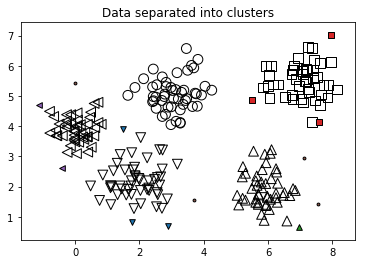

In [24]:
# Extracts the core samples from the trained model
mask_core = np.zeros(labels.shape, dtype=np.bool)
mask_core[model.core_sample_indices_] = True

# Plot resultant clusters 
plt.figure()
labels_uniq = set(labels)
markers = cycle('vo^s<>')
for cur_label, marker in zip(labels_uniq, markers):
    # Use black dots for unassigned datapoints
    if cur_label == -1:
        marker = '.'

    # Create mask for the current label
    cur_mask = (labels == cur_label)

    cur_data = X[cur_mask & mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=96, facecolors='none')

    cur_data = X[cur_mask & ~mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=32)

plt.title('Data separated into clusters')
plt.show()

### Finding Patterns in Stock Market Data

In [26]:
import json
import datetime
import sys
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn import covariance, cluster

In [27]:
# Input symbol file

symbol_file = 'Python-Machine-Learning-Cookbook-Second-Edition-master/Chapter04/symbol_map.json'

with open(symbol_file, 'r') as f:
    symbol_dict = json.loads(f.read())

symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    quotes.append(pd.read_csv(url.format(symbol)))
    
closing_quotes = np.vstack([q['close'] for q in quotes])
opening_quotes = np.vstack([q['open'] for q in quotes])

# The daily fluctuations of the quotes 
delta_quotes = closing_quotes - opening_quotes

Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'YHOO'


In [36]:
# Build a graph model from the correlations
edge_model = covariance.GraphicalLassoCV(cv=3)

# Standardize the data 
X = delta_quotes.copy().T
X /= X.std(axis=0)

# Train the model
with np.errstate(invalid='ignore'):
    edge_model.fit(X)

In [39]:
# Build clustering model using affinity propagation
_, labels = cluster.affinity_propagation(edge_model.covariance_)
num_labels = labels.max()

# Print the results of clustering
for i in range(num_labels + 1):
    print("Cluster", i+1, "-->", ', '.join(names[labels == i]))

Cluster 1 --> Apple, Amazon, Yahoo
Cluster 2 --> AIG, American express, Bank of America, DuPont de Nemours, General Dynamics, General Electrics, Goldman Sachs, GlaxoSmithKline, Home Depot, Kellogg
Cluster 3 --> Boeing, Canon, Caterpillar, Ford, Honda
Cluster 4 --> Cisco, Dell, HP, IBM
Cluster 5 --> Comcast, Cablevision
Cluster 6 --> CVS
Cluster 7 --> ConocoPhillips, Chevron
Cluster 8 --> Colgate-Palmolive, Kimberly-Clark


### Building a Customer Segmentation Model

In [40]:
import csv

import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

In [43]:
# Load data from input file
input_file = 'Python-Machine-Learning-Cookbook-Second-Edition-master/Chapter04/wholesale.csv'
file_reader = csv.reader(open(input_file, 'rt'), delimiter=',')
X = []
for count, row in enumerate(file_reader):
    if not count:
        names = row[2:]
        continue

    X.append([float(x) for x in row[2:]])

# Input data as numpy array
X = np.array(X)

In [45]:
# Estimating the bandwidth 
bandwidth = estimate_bandwidth(X, quantile=0.8, n_samples=len(X))

# Compute clustering with MeanShift
meanshift_estimator = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift_estimator.fit(X)
labels = meanshift_estimator.labels_
centroids = meanshift_estimator.cluster_centers_
num_clusters = len(np.unique(labels))

print("Number of clusters in input data =", num_clusters)

print("Centroids of clusters:")
print('\t'.join([name[:3] for name in names]))
for centroid in centroids:
    print('\t'.join([str(int(x)) for x in centroid]))

Number of clusters in input data = 8
Centroids of clusters:
Fre	Mil	Gro	Fro	Det	Del
9632	4671	6593	2570	2296	1248
40204	46314	57584	5518	25436	4241
112151	29627	18148	16745	4948	8550
36847	43950	20170	36534	239	47943
32717	16784	13626	60869	1272	5609
22925	73498	32114	987	20070	903
16117	46197	92780	1026	40827	2944
8565	4980	67298	131	38102	1215


In [54]:
centroids.shape

(8, 6)

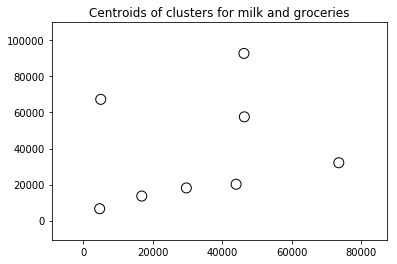

In [46]:
# Visualizing data

centroids_milk_groceries = centroids[:, 1:3]

# Plot the nodes using the coordinates of our centroids_milk_groceries
plt.figure()
plt.scatter(centroids_milk_groceries[:,0], centroids_milk_groceries[:,1], 
        s=100, edgecolors='k', facecolors='none')

offset = 0.2
plt.xlim(centroids_milk_groceries[:,0].min() - offset * centroids_milk_groceries[:,0].ptp(),
        centroids_milk_groceries[:,0].max() + offset * centroids_milk_groceries[:,0].ptp(),)
plt.ylim(centroids_milk_groceries[:,1].min() - offset * centroids_milk_groceries[:,1].ptp(),
        centroids_milk_groceries[:,1].max() + offset * centroids_milk_groceries[:,1].ptp())

plt.title('Centroids of clusters for milk and groceries')
plt.show()

### Using Autoencoders to Reconstruct Handwritten Digit Images

In [1]:
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(XTrain, YTrain), (XTest, YTest) = mnist.load_data()

print('XTrain shape = ',XTrain.shape)
print('XTest shape = ',XTest.shape)
print('YTrain shape = ',YTrain.shape)
print('YTest shape = ',YTest.shape)

XTrain shape =  (60000, 28, 28)
XTest shape =  (10000, 28, 28)
YTrain shape =  (60000,)
YTest shape =  (10000,)


In [3]:
import numpy as np
print('YTrain values = ',np.unique(YTrain))
print('YTest values = ',np.unique(YTest))

unique, counts = np.unique(YTrain, return_counts=True)
print('YTrain distribution = ',dict(zip(unique, counts)))
unique, counts = np.unique(YTest, return_counts=True)
print('YTrain distribution = ',dict(zip(unique, counts)))

YTrain values =  [0 1 2 3 4 5 6 7 8 9]
YTest values =  [0 1 2 3 4 5 6 7 8 9]
YTrain distribution =  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
YTrain distribution =  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


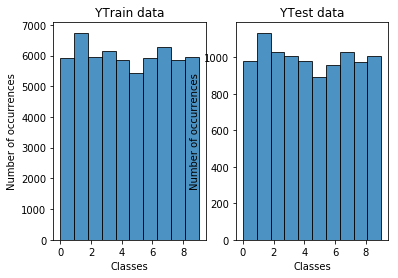

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(121)
plt.hist(YTrain, alpha=0.8, ec='black')
plt.xlabel("Classes")
plt.ylabel("Number of occurrences")
plt.title("YTrain data")

plt.subplot(122)
plt.hist(YTest, alpha=0.8, ec='black')
plt.xlabel("Classes")
plt.ylabel("Number of occurrences")
plt.title("YTest data")
plt.show()

In [6]:
XTrain = XTrain.astype('float32') / 255
XTest = XTest.astype('float32') / 255

XTrain = XTrain.reshape((len(XTrain), np.prod(XTrain.shape[1:])))
XTest = XTest.reshape((len(XTest), np.prod(XTest.shape[1:])))

In [7]:
from keras.layers import Input 
from keras.layers import Dense
from keras.models import Model

InputModel = Input(shape=(784,))
EncodedLayer = Dense(32, activation='relu')(InputModel)
DecodedLayer = Dense(784, activation='sigmoid')(EncodedLayer)

AutoencoderModel = Model(InputModel, DecodedLayer)

AutoencoderModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [8]:
AutoencoderModel.compile(optimizer='adadelta', loss='binary_crossentropy')

history = AutoencoderModel.fit(XTrain, XTrain,
                    batch_size=256,
                    epochs=100,
                    shuffle=True,
                    validation_data=(XTest, XTest))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.3793 - val_loss: 0.2739
Epoch 2/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.2693 - val_loss: 0.2622
Epoch 3/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.2534 - val_loss: 0.2417
Epoch 4/100
60000/60000 [==============================] - 3s 44us/step - loss: 0.2333 - val_loss: 0.2225
Epoch 5/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.2159 - val_loss: 0.2068
Epoch 6/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.2025 - val_loss: 0.1955
Epoch 7/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1926 - val_loss: 0.1868
Epoch 8/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1849 - val_loss: 0.1801
Epoch 9/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1788 - val_loss: 0.1

60000/60000 [==============================] - 3s 43us/step - loss: 0.1017 - val_loss: 0.1001
Epoch 78/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.1017 - val_loss: 0.1000
Epoch 79/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.1016 - val_loss: 0.0999
Epoch 80/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.1015 - val_loss: 0.0998
Epoch 81/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.1014 - val_loss: 0.0998
Epoch 82/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.1013 - val_loss: 0.0997
Epoch 83/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1012 - val_loss: 0.0996
Epoch 84/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.1011 - val_loss: 0.0995
Epoch 85/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.1011 - val_loss: 0.0995
Epoch 86/100
60000/60000 [========================

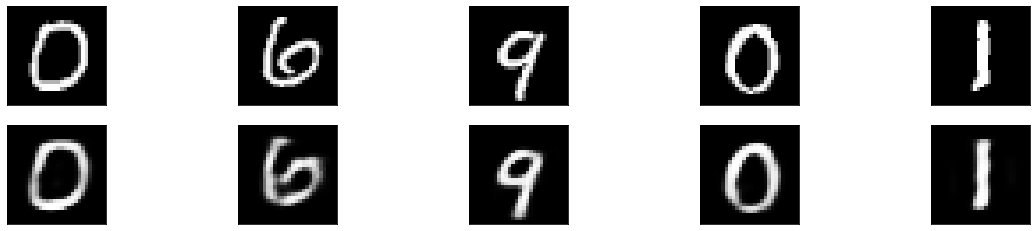

In [13]:
DecodedDigits = AutoencoderModel.predict(XTest)

n=5
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(XTest[i+10].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(DecodedDigits[i+10].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()